### Robert Bellido

### CISB 63

### Final Project

### Fall 2023

### Professor Angel Martinon Hernandez


## seq2seq & TF-IDF chatbot


# Introduction and Summary

In this file, we will implement a basic sequence-to-sequence chatbot. The chatbot is trained on a dataset of conversations, and it uses an encoder-decoder architecture with LSTM (Long Short-Term Memory) layers. The model is trained on this data to learn patterns and generate relevant responses. In this example, we will use a YAML file. We will also study the entities of question and answers.

YAML is a human-readable data serialization format. It is often used for configuration files and data exchange between languages with different data structures. YAML is designed to be easily readable by humans and can be used for configuration files where data readability is a priority.

### Steps:

#### Import Libraries:

- TensorFlow and Keras are used for building and training the neural network.
- NumPy for numerical operations.
- OS for interacting with the operating system.
- YAML for parsing YAML files.
- Load and Preprocess Data:

#### The code reads conversation data from YAML files in the specified directory.
- It extracts questions and answers from the conversations.
- It preprocesses the answers by adding START and END tags.
- Tokenization is performed on both questions and answers using the Keras Tokenizer.
- Tokenization and Padding:

#### Study the answers and question in the imported YAML file(s)

- load the files into spacy
- Display the entities
- plot the entitities (histogram, line chart)

#### Tokenizer is fitted on both questions and answers to create a vocabulary.
- The questions and answers are then converted to sequences of integers using the tokenizer.
- Padding is applied to make all sequences of equal length.

#### Define Model:

- The model consists of an encoder and a decoder.
- The encoder processes the input sequences (questions).
- The decoder takes the output of the encoder and generates the output sequences (answers).
- Embedding layers are used for word embeddings.
- LSTM layers are employed for sequence processing.
- The model is compiled using the RMSprop optimizer and categorical cross-entropy loss.


#### Training:
- The model is trained on the preprocessed data using the fit function.

#### Inference Models:
- Inference models are created for the encoder and decoder to generate responses.
- The encoder model takes a question and produces the internal states of the encoder LSTM.
- The decoder model generates responses using the encoder states and initial input.

#### User Interaction:
- The user can interact with the trained chatbot by entering a question.
- The question is tokenized, and the inference models are used to generate a response.

#### Loop for Interaction:
- The chatbot runs in a loop, allowing the user to input multiple questions and receive corresponding responses.

# Importing classes

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from keras import Input, Model
from keras.activations import softmax
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import preprocessing , utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os # os for interacting with the operating system.
import yaml #  for parsing YAML files.


from spacy import displacy
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

#### Let's prepare a dataset by extracting conversations from YAML files, combining them into questions and answers, and then tokenizing the text for further use in training a chatbot model.

#### for filepath in files_list:
- It iterates through each file in the directory. 
- For each file, it opens and reads the YAML content using yaml.safe_load.
- It extracts conversations from the YAML content and appends the questions and answers to the respective lists.
- If a conversation has more than two elements, it combines all elements (except the first one) into a single string as an answer.



In [2]:
#data extracted from https://github.com/shubham0204/Dataset_Archives/blob/master/chatbot_nlp.zip
dir_path = 'chatbot_nlp/data'
files_list = os.listdir(dir_path + os.sep)

questions = list()
answers = list()
actual_text = str()

for filepath in files_list:
    stream = open( dir_path + os.sep + filepath , 'rb')
    docs = yaml.safe_load(stream)
    conversations = docs['conversations']
    actual_text = actual_text + str(conversations)
    for con in conversations:
        if len( con ) > 2 :
            questions.append(con[0])
            replies = con[ 1 : ]
            ans = ''
            for rep in replies:
                ans += ' ' + rep
            answers.append( ans )
        elif len( con )> 1:
            questions.append(con[0])
            answers.append(con[1])

# Adding Tags to Answers
#Let's filters out invalid answers (non-string types) and creates a list of valid answers. 
answers_with_tags = list()
for i in range( len( answers ) ):
    if type( answers[i] ) == str:
        answers_with_tags.append( answers[i] )
    else:
        questions.pop( i )

# Preprocessing Answers with Start and End Tags:
# we are adding start (<START>) and end (<END>) tags to each answer.
answers = list()
for i in range( len( answers_with_tags ) ) :
    answers.append( '<START> ' + answers_with_tags[i] + ' <END>' )

# Tokenization:
# It initializes a Keras Tokenizer and fits it on both questions and answers combined.
tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( questions + answers )

# VOCAB_SIZE is set to the size of the vocabulary 
# (the number of unique words in the combined questions and answers).
# It prints the size of the vocabulary.

VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

#tokenizer.word_index is a dictionary that maps words to their respective integer indices. 
# It is created by the fit_on_texts method of the Keras Tokenizer during the tokenization process.

VOCAB SIZE : 309


In [3]:
#load the en_core_web_sm
nlp = spacy.load('en_core_web_sm')

#instatiate the text
spcy_hp1 = nlp(actual_text)

In [4]:
#a for loop to display the entities in the text
for x in spcy_hp1.ents:
    print(f'{x.text}: {x.label_}')

British: NORP
Charles Babbage: PERSON
John von Neumann: PERSON
Princeton: PERSON
first: ORDINAL
ENIAC: ORG
first: ORDINAL
University of Pennsylvania: ORG
1946: DATE
first: ORDINAL
the Jacquard Loom: PERSON
Windows: NORP
Linux: GPE
UNIX: ORG
OSes: FAC
Android: PERSON
Windows: NORP
Linux: PERSON
Linux: GPE
Apple: ORG
Microsft: PRODUCT
HP: ORG
several hundred: CARDINAL
MET: ORG
NASA: ORG
the american civil war': EVENT
the american civil war': EVENT
two: CARDINAL
thomas edison: PERSON
james watt: PERSON


In [5]:
#highlight the entities
displacy.render(spcy_hp1, style='ent')

In [6]:
#function to separate and clean the text from punctuation
def separate_punc(doc_text):
    return [token.text.lower() for token in nlp(doc_text) if token.text not in '\n\n \n\n\n!"-#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~\t\n ']

In [7]:
#run the function to remove punctuations
token_hp1 = separate_punc(spcy_hp1)

In [11]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [12]:
nltk.pos_tag(token_hp1)

[("'", 'POS'),
 ('what', 'WP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('computer', 'NN'),
 ("'", "''"),
 ("'", "''"),
 ('a', 'DT'),
 ('computer', 'NN'),
 ('is', 'VBZ'),
 ('an', 'DT'),
 ('electronic', 'JJ'),
 ('device', 'NN'),
 ('which', 'WDT'),
 ('takes', 'VBZ'),
 ('information', 'NN'),
 ('in', 'IN'),
 ('digital', 'JJ'),
 ('form', 'NN'),
 ('and', 'CC'),
 ('performs', 'VBZ'),
 ('a', 'DT'),
 ('series', 'NN'),
 ('of', 'IN'),
 ('operations', 'NNS'),
 ('based', 'VBN'),
 ('on', 'IN'),
 ('predetermined', 'JJ'),
 ('instructions', 'NNS'),
 ('to', 'TO'),
 ('give', 'VB'),
 ('some', 'DT'),
 ('output', 'NN'),
 ("'", "''"),
 ('the', 'DT'),
 ('thing', 'NN'),
 ('you', 'PRP'),
 ("'re", 'VBP'),
 ('using', 'VBG'),
 ('to', 'TO'),
 ('talk', 'VB'),
 ('to', 'TO'),
 ('me', 'PRP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('computer', 'NN'),
 ("'", "''"),
 ('an', 'DT'),
 ('electronic', 'JJ'),
 ('device', 'NN'),
 ('capable', 'NN'),
 ('of', 'IN'),
 ('performing', 'VBG'),
 ('calculations', 'NNS'),
 ('at', 'IN'),
 ('very', 'RB'),


In [13]:
hp1_nop = []

for w in token_hp1:
    if w.isalpha():
        hp1_nop.append(w.lower())
    
print(hp1_nop)

['what', 'is', 'a', 'computer', 'a', 'computer', 'is', 'an', 'electronic', 'device', 'which', 'takes', 'information', 'in', 'digital', 'form', 'and', 'performs', 'a', 'series', 'of', 'operations', 'based', 'on', 'predetermined', 'instructions', 'to', 'give', 'some', 'output', 'the', 'thing', 'you', 'using', 'to', 'talk', 'to', 'me', 'is', 'a', 'computer', 'an', 'electronic', 'device', 'capable', 'of', 'performing', 'calculations', 'at', 'very', 'high', 'speed', 'and', 'with', 'very', 'high', 'accuracy', 'a', 'device', 'which', 'maps', 'one', 'set', 'of', 'numbers', 'onto', 'another', 'set', 'of', 'numbers', 'what', 'is', 'a', 'super', 'computer', 'computers', 'which', 'can', 'perform', 'very', 'large', 'numbers', 'of', 'calculations', 'at', 'very', 'high', 'speed', 'and', 'accuracy', 'are', 'called', 'super', 'computers', 'a', 'supercomputer', 'is', 'a', 'computer', 'which', 'operates', 'at', 'several', 'orders', 'of', 'magnatude', 'greater', 'speed', 'and', 'capacity', 'than', 'everyd

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rbellido\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [16]:
#instatiate the stop words
stpwords = stopwords.words('english')

#empty list to append to
hp1_stp_clean = []

# for loop to remove stopwords
for w in hp1_nop:
    if w not in stpwords:
        hp1_stp_clean.append(w)
        
print(hp1_stp_clean)

['computer', 'computer', 'electronic', 'device', 'takes', 'information', 'digital', 'form', 'performs', 'series', 'operations', 'based', 'predetermined', 'instructions', 'give', 'output', 'thing', 'using', 'talk', 'computer', 'electronic', 'device', 'capable', 'performing', 'calculations', 'high', 'speed', 'high', 'accuracy', 'device', 'maps', 'one', 'set', 'numbers', 'onto', 'another', 'set', 'numbers', 'super', 'computer', 'computers', 'perform', 'large', 'numbers', 'calculations', 'high', 'speed', 'accuracy', 'called', 'super', 'computers', 'supercomputer', 'computer', 'operates', 'several', 'orders', 'magnatude', 'greater', 'speed', 'capacity', 'everyday', 'general', 'purpose', 'computers', 'like', 'one', 'talking', 'know', 'big', 'iron', 'invented', 'computers', 'bit', 'ambigous', 'british', 'scientist', 'charles', 'babbage', 'regarded', 'father', 'computers', 'one', 'might', 'argue', 'john', 'von', 'neumann', 'invented', 'computers', 'know', 'invented', 'princeton', 'architecture

[('computer', 17), ('computers', 12), ('history', 8), ('numbers', 5), ('large', 5), ('invented', 5), ('software', 5), ('device', 4), ('instructions', 4), ('calculations', 4)]


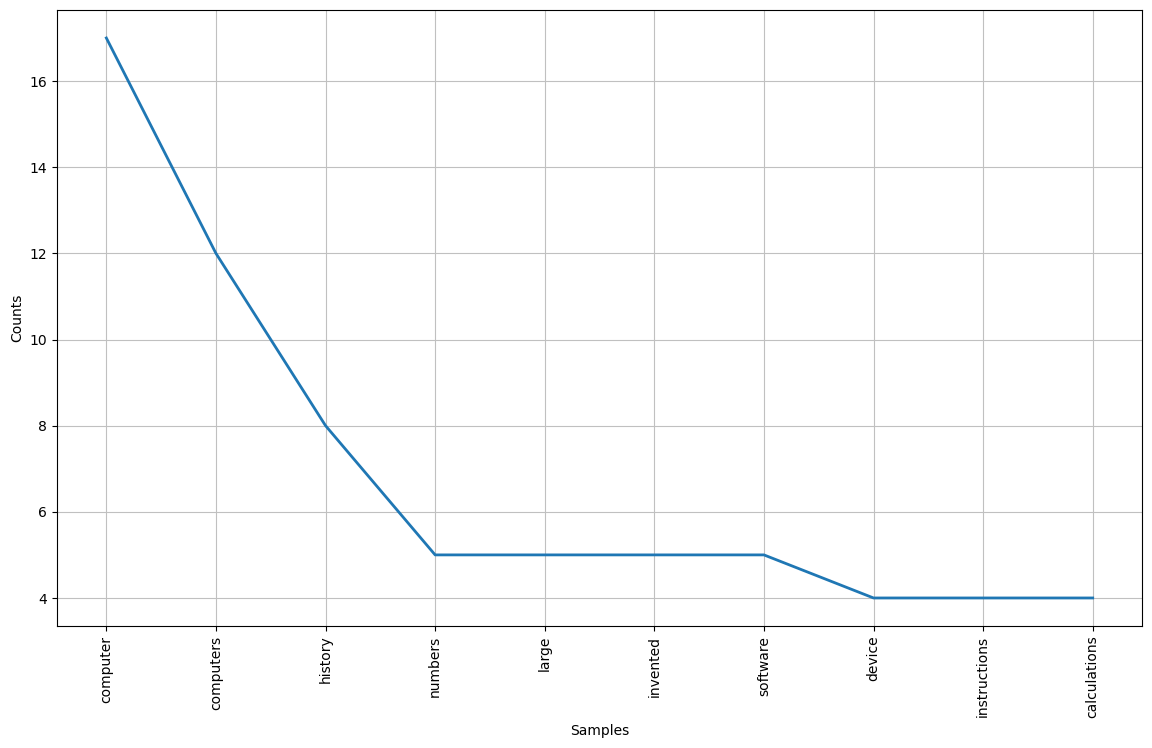

<Axes: xlabel='Samples', ylabel='Counts'>

In [17]:
#plot the frequency of the cleaned text
hp1_fd = FreqDist(hp1_stp_clean)

print(hp1_fd.most_common(10))
plt.figure(figsize=(14,8))
hp1_fd.plot(10)


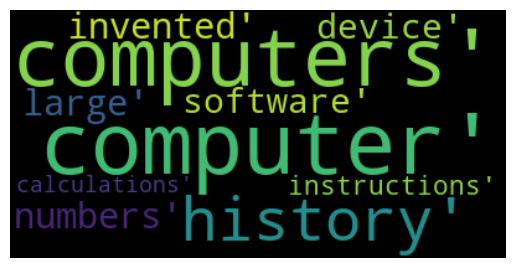

In [18]:
# Create and generate a word cloud image
wordcloud = WordCloud().generate(str(hp1_fd.most_common(10)))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### Let's process and prepare the input data for the encoder of a sequence-to-sequence chatbot model.
- Tokenize the Questions
- Determine Maximum Length of Questions
- Padding of Questions Sequences
- Convert to NumPy Array
- Print the shape of the encoder_input_data array, which represents the dimensions (number of samples, sequence length).

### The pad_sequences function from Keras:
- The function is used to pad sequences of tokenized questions to a uniform length.

tokenized_questions 
- This is a list of sequences, where each sequence represents a question, and each element in the sequence is the integer index corresponding to a word in the vocabulary.

maxlen=maxlen_questions: 
- This parameter specifies the maximum length of the padded sequences. If a sequence is shorter than maxlen_questions, it will be padded to reach this length. If it's longer, it will be truncated.

padding='post': 
- This parameter determines where to add the padding. In this case, 'post' means that the padding will be added to the end of each sequence. If it were set to 'pre', padding would be added to the beginning.

The result, padded_questions, is a 2D NumPy array where each row corresponds to a sequence of tokenized questions, and the sequences are padded or truncated to have the same length (maxlen_questions). 

In [19]:
# encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences( questions )
maxlen_questions = max( [ len(x) for x in tokenized_questions ] )
padded_questions = preprocessing.sequence.pad_sequences( tokenized_questions , maxlen=maxlen_questions , padding='post' )
encoder_input_data = np.array( padded_questions )
print( encoder_input_data.shape , maxlen_questions )

(18, 8) 8


### Let's process and prepare the input data for the decoder of a sequence-to-sequence chatbot model.
- Tokenize the Answers
- Determine Maximum Length of Answers  
- Padding of Answers Sequences
- Convert to NumPy Array
- print the shape of the decoder_input_data array, which represents the dimensions (number of samples, sequence length).
- print the maxlen_answers, which is the maximum length of the padded sequences.

In [20]:
# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
maxlen_answers = max( [ len(x) for x in tokenized_answers ] )
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
decoder_input_data = np.array( padded_answers )
print( decoder_input_data.shape , maxlen_answers )

(18, 74) 74


#### Let's prepare the target (output) data for the decoder of a sequence-to-sequence chatbot model. We need to tokenize the answers, remove the START tag, pad the sequences, and performe one-hot encoding to create the final format suitable for training the neural network.
- Tokenization of Answers
- Remove the START Tag
- Padding of Answers Sequences
- One-Hot Encoding of Padded Sequences
- Convert to NumPy Array
- Print the shape of the decoder_output_data array, which represents the dimensions (number of samples, sequence length, vocabulary size).

In [21]:
# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences( answers )

# It removes the first element (corresponding to <START>) from each tokenized answer sequence. 
# This is because the decoder's input will be <START> followed by the actual sequence, 
# and the target (output) should be the actual sequence.
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
    
# It pads the sequences of tokenized answers to make them all have the same length.    
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )

# Let's perform one-hot encoding on the padded sequences.
# VOCAB_SIZE is the size of the vocabulary, 
# and each element in the one-hot encoding corresponds to a word in the vocabulary.
onehot_answers = utils.to_categorical( padded_answers , VOCAB_SIZE )

# Let's convert the one-hot encoded sequences into a NumPy array.
decoder_output_data = np.array( onehot_answers )
print( decoder_output_data.shape )


(18, 74, 309)


#### Let's define a sequence-to-sequence model for a chatbot using TensorFlow and Keras. 

### steps:
- Define an input layer for the encoder
- Add the Encoder Embedding Layer
- Add the Encoder LSTM Layer
- Encoder States: It creates a list containing the hidden state (state_h) and cell state (state_c) of the encoder LSTM. These states will be used to initialize the decoder LSTM.
- Add the Decoder Input Layer
- Add the Decoder Embedding Layer
- Add the Decoder LSTM Layer
- Add the Decoder Dense Layer
- Construction the model
- Compile the model
- Print the summary of the model

In [22]:
# We need to define an input layer for the encoder
# shape=(maxlen_questions,) specifies the shape of the input, 
# where maxlen_questions is the maximum length of the input sequences.
encoder_inputs = tf.keras.layers.Input(shape=( maxlen_questions , ))

# It adds an embedding layer to the encoder.
# VOCAB_SIZE is the size of the vocabulary.
# 200 is the dimensionality of the embedding.
# mask_zero=True masks the padded zeros in the input sequences.
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True ) (encoder_inputs)

# It adds an LSTM layer to the encoder.
# 200 is the number of units in the LSTM layer.
# return_state=True returns the hidden state and cell state as part of the output.
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 200 , return_state=True )( encoder_embedding )

# Let's create a list containing the hidden state (state_h) and cell state (state_c) of the encoder LSTM.
encoder_states = [ state_h , state_c ]

# Let's define an input layer for the decoder.
# shape=(maxlen_answers,) specifies the shape of the input, 
# where maxlen_answers is the maximum length of the output sequences.
decoder_inputs = tf.keras.layers.Input(shape=( maxlen_answers ,  ))

# Let's adds an embedding layer to the decoder with the same configuration as the encoder's embedding layer.
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True) (decoder_inputs)

# Decoder LSTM Layer:
# We are adding an LSTM layer to the decoder.
#return_state=True returns the hidden state and cell state as part of the output.
#return_sequences=True returns the full sequence of outputs for each timestep.
decoder_lstm = tf.keras.layers.LSTM( 200 , return_state=True , return_sequences=True )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )

# Let's add the Decoder Dense Layer:
# It adds a dense layer to the decoder with a softmax activation function.
# The output is the probability distribution over the vocabulary for each timestep.
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

# It constructs the final model with both encoder and decoder inputs and the output.
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )

# Let's compiles the model, specifying the RMSprop optimizer and categorical cross-entropy as the loss function.
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy')

# Print the model architecture, including layer names, types, output shapes, and the number of parameters.
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 74)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 8, 200)               61800     ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 74, 200)              61800     ['input_2[0][0]']             
                                                                                              

### Let's train the neural network and save the model

We are training a sequence-to-sequence model for our chatbot

In [23]:
model.fit([encoder_input_data , decoder_input_data], decoder_output_data, batch_size=32, epochs=400 ) 
model.save( 'model.keras' )


Epoch 1/400
1/1 [==============================] - 10s 10s/step - loss: 5.7338
Epoch 2/400
1/1 [==============================] - 0s 62ms/step - loss: 5.7278
Epoch 3/400
1/1 [==============================] - 0s 56ms/step - loss: 5.7230
Epoch 4/400
1/1 [==============================] - 0s 56ms/step - loss: 5.7185
Epoch 5/400
1/1 [==============================] - 0s 60ms/step - loss: 5.7137
Epoch 6/400
1/1 [==============================] - 0s 55ms/step - loss: 5.7084
Epoch 7/400
1/1 [==============================] - 0s 60ms/step - loss: 5.7018
Epoch 8/400
1/1 [==============================] - 0s 58ms/step - loss: 5.6926
Epoch 9/400
1/1 [==============================] - 0s 61ms/step - loss: 5.6769
Epoch 10/400
1/1 [==============================] - 0s 56ms/step - loss: 5.6365
Epoch 11/400
1/1 [==============================] - 0s 58ms/step - loss: 5.5044
Epoch 12/400
1/1 [==============================] - 0s 58ms/step - loss: 5.3852
Epoch 13/400
1/1 [==============================]

### Now, we are going to defines a function, make_inference_models, which is responsible for creating inference models for both the encoder and decoder parts of a sequence-to-sequence chatbot model.

steps:
- Create a Keras model for the encoder.
- Define the input layers for the initial hidden state (decoder_state_input_h) and cell state (decoder_state_input_c) of the decoder LSTM. These input layers will be used during the inference phase to initialize the decoder LSTM states.
- Create a list containing the input layers for the decoder LSTM states (Decoder States Inputs List). his list will be used when defining the decoder model.
- Apply the decoder LSTM to the embedded decoder inputs (decoder_embedding), using the provided initial states (decoder_states_inputs). The resulting decoder_outputs are the output sequences, and the final LSTM states (state_h and state_c) are obtained.
- Apply the dense layer to the decoder outputs, producing the final output probabilities over the vocabulary.
- Create a Keras model for the decoder:
     - The inputs are the decoder inputs and the initial states of the decoder LSTM.
     - The outputs are the decoder outputs and the final LSTM states.
     - This model is used during the inference phase to generate responses based on the encoded input and the previously generated  tokens.


In [24]:
def make_inference_models():
    
    # model for the encoder.
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    # Decoder State Inputs:
    decoder_state_input_h = tf.keras.layers.Input(shape=( 200 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 200 ,))
    
    #Decoder States Inputs List
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    # Decoder Outputs and States
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    
    # Decoder Dense Layer
    decoder_outputs = decoder_dense(decoder_outputs)
    
    #Decoder Model
    # It returns both the encoder and decoder models
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model


#### We need a function to convert a given input sentence (string) into a sequence of tokens suitable for input to the chatbot model.
Steps:
- Input Sentence Processing
- Tokenization
- Padding Sequences
- Output


In [25]:
def str_to_tokens( sentence : str ):
    # converts the input sentence to lowercase
    # and splits the sentence into a list of words
    words = sentence.lower().split()
    
    # Tokenization
    # It iterates through the list of words and uses the Keras Tokenizer (tokenizer) 
    # to convert each word to its corresponding integer index.
    # The result is a list of tokenized indices representing the words in the input sentence.
    tokens_list = list()
    for word in words:
        tokens_list.append( tokenizer.word_index[ word ] ) 
    
    #Padding Sequences
    #It takes the list of tokenized indices (tokens_list) and pads 
    # or truncates the sequence to ensure it has the same length (maxlen_questions) 
    # as expected by the model.
    # maxlen=maxlen_questions specifies the maximum length of the padded sequence.
    # padding='post' indicates that padding should be added to the end of the sequence.
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=maxlen_questions , padding='post')

    # Output
    #The function returns the padded sequence of tokenized indices, 
    #which will be used as input to the chatbot model during the inference phase.

#### In the last part, we need an interface to interact with the chatbot by entering questions, and the chatbot responds with generated answers using the trained sequence-to-sequence model. The interaction continues until the user decides to exit by typing "bye."

#### We need an interactive loop where a user can input questions, and the chatbot generates responses using the trained sequence-to-sequence model. 

Steps:
- Inference Model Initialization
    - enc_model, dec_model = make_inference_models()
- Interactive Loop: 
    - while True:
- User Input
    - user_input = input('Enter question (type "bye" to exit): ')
- Check for Exit Command
    - if user_input.lower() == 'bye'
- Encode User Input
    - states_values = enc_model.predict(str_to_tokens(user_input))
- Initialize Target Sequence and Decoded Translation
- Decoding Loop
    - while not stop_condition
- Word Lookup and Decoded Translation Update
- Stopping Condition Check
- Update Target Sequence and States
- Print Generated Response

In [27]:
# 1. Inference Model Initialization
enc_model, dec_model = make_inference_models()

# 2. Interactive Loop
while True:
    # 3. User Input
    user_input = input('Enter question (type "bye" to exit): ')
    
    # initializing punctuations string
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    
    # Removing punctuations in string
    # Using loop + punctuation string
    for ele in user_input:
        if ele in punc:
            user_input = user_input.replace(ele, "")
        
    # 4. Check if the user wants to exit
    if user_input.lower() == 'bye':
        print('Goodbye!')
        break
    
    # 5. Encode User Input
    # It tokenizes and encodes the user's input using the encoder model 
    # to obtain the initial states for the decoder.
    states_values = enc_model.predict(str_to_tokens(user_input))
    
    # 6. Initialize Target Sequence and Decoded Translation
    # It initializes the target sequence for the decoder with a single <START> token.
    # It sets up variables for stopping the generation loop and storing the decoded translation.
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    
    # 7. Decoding Loop
    # It runs a loop until a stopping condition is met
    # The decoder model predicts the next word in the sequence (sampled_word_index) 
    # based on the current target sequence and states.
    while not stop_condition:
        dec_outputs, h, c = dec_model.predict([empty_target_seq] + states_values)
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])

        # 8. Word Lookup and Decoded Translation Update
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                decoded_translation += ' {}'.format(word)
                sampled_word = word

        # 9. Stopping Condition Check   
        # It checks whether the generated word is the <END> token or if the length of 
        # the generated translation exceeds a certain limit, signaling the end of the generation.
        if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
            stop_condition = True

        # Update Target Sequence and States    
        # it updates the target sequence for the next iteration and the states for the next prediction
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h, c]

    # 11. It prints the generated response after each iteration of the inference loop
    print('Chatbot:', decoded_translation)
    

Enter question (type "bye" to exit): what is a computer
1/1 [==============================] - 0s 19ms/step
Chatbot:  computers which can very large numbers of calculations at very high speed and accuracy are called super a supercomputer is a computer is a computer which operates which operates several orders of magnatude greater and capacity than everyday everyday general purpose a computer an a computer an electronic an electronic electronic electronic all of calculations of calculations and basic access and peripheral access end
Enter question (type "bye" to exit): bye
Goodbye!


# Simple Chatbot using Transformer

#### Let's tokenize the text and convert data in matrix format

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X_vec = vectorizer.fit_transform(questions)

#### Let's Transform data by applying term frequency inverse document frequency (TF-IDF) 

In [29]:
tfidf = TfidfTransformer() 
X_tfidf = tfidf.fit_transform(X_vec)

In [30]:
tfidf

TfidfTransformer()

In [31]:
X_tfidf

<18x25 sparse matrix of type '<class 'numpy.float64'>'
	with 39 stored elements in Compressed Sparse Row format>

# X_tfidf is the repository matrix that will be searched every time a new question is entered in the chatbot for the most similar question. 
#### Let's do a functions "conversation"

#### We need to calculate the angle between every row of the X_tfidf matrix and the new question vector. Note that we are using skelearn cosine_similarity module to calculate the cosine between each row and the vector and then convert the cosine into degrees. 

#### Finally, we search the row that has the maximum cosine (or the minimum angle) with the new question vector and return the corresponding answer. 

In [32]:
def conversation(im):
    global tfidf, answers, X_tfidf
    Y_vec = vectorizer.transform(im)
    Y_tfidf = tfidf.fit_transform(Y_vec)
    cos_sim = np.rad2deg(np.arccos(max(cosine_similarity(Y_tfidf, X_tfidf)[0])))
    if cos_sim > 30:
        return "sorry, I did not quite understand that"
    else: 
        return answers[np.argmax(cosine_similarity(Y_tfidf, X_tfidf)[0])]

#### Finally, let's implement the chat where the user enters a question and the bot provides a response. The chat continues until the user types "bye"

In [33]:
def main():
    usr = input('Enter your name: ')
    print("Support: Hi, welcome to Q&A support. How can I help you?")
    while True:
        im = input("{}: ".format(usr))
        if im.lower() == 'bye':
            print("Q&A support: bye!")
            break
        else:
            print("Q&A support: " +conversation([im]))

In [34]:
main()

Enter your name: Robert Bellido 
Support: Hi, welcome to Q&A support. How can I help you?
Robert Bellido : what is a computer
Q&A support: <START>  A computer is an electronic device which takes information in digital form and performs a series of operations based on predetermined instructions to give some output. The thing you're using to talk to me is a computer. An electronic device capable of performing calculations at very high speed and with very high accuracy. A device which maps one set of numbers onto another set of numbers. <END>
Robert Bellido : what is a cpu
Q&A support: sorry, I did not quite understand that
Robert Bellido : what is a RAM
Q&A support: sorry, I did not quite understand that
Robert Bellido : bye
Q&A support: bye!


# Conclusions

First chatbot was limited, nonetheless, it was better than the second one.
Second chatbot needs more improvement in order compete and/or be at the same level as the first one.

Moving forward, if we are to use a chatbot, then, the Sequence to Sequence (seq2seq) is better than td-idf.  I enjoy very 
much testing both models and I look forward to applying this learning experience in professional career.

Thank you very much!
